In [5]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split


In [6]:
![ ! -f ashrae-energy-prediction.zip ] && kaggle competitions download -c ashrae-energy-prediction

In [8]:
!unzip -n ashrae-energy-prediction.zip -d data

Archive:  ashrae-energy-prediction.zip


In [9]:
buildings = pd.read_csv("data/building_metadata.csv")
buildings = buildings.fillna(buildings.mean())
weather = pd.read_csv("data/weather_train.csv")
weather = weather.fillna(weather.mean())
df = pd.read_csv('data/train.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

/var/folders/4c/y7d9384d7g17636gh79f9zjc0000gn/T/ipykernel_61750/2277061764.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  buildings = buildings.fillna(buildings.mean())
/var/folders/4c/y7d9384d7g17636gh79f9zjc0000gn/T/ipykernel_61750/2277061764.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  weather = weather.fillna(weather.mean())


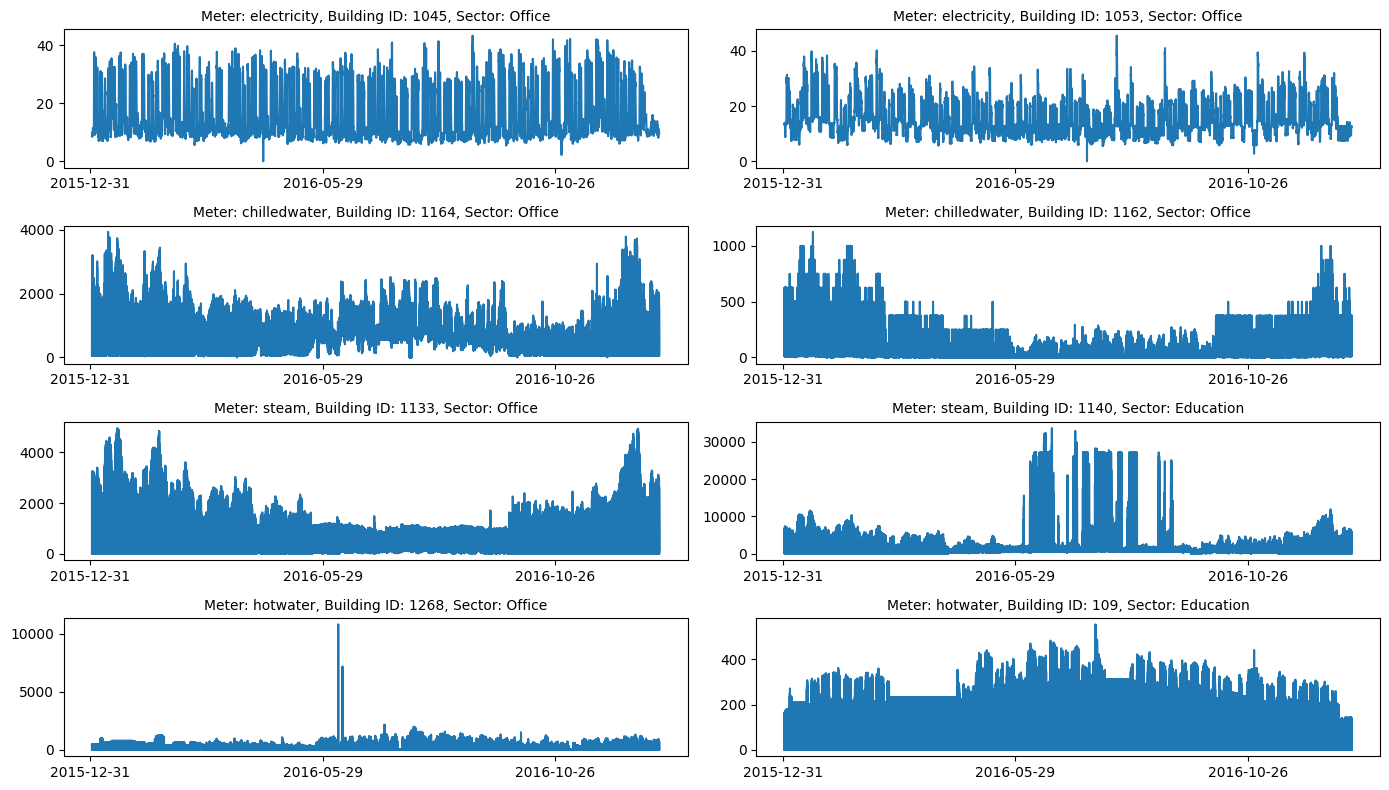

In [26]:
meters = ["electricity", "chilledwater", "steam", "hotwater"]
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(14,8))

for meter_id, meter_name in enumerate(meters):
    building_ids = df[df['meter'] == meter_id]['building_id'].value_counts().index[8:16]
    for i in range(2):
        # Plotting buildings with most data points
        building_id = building_ids[i]
        sector = buildings[buildings['building_id'] == building_id]['primary_use'].values[0]
        
        plot_data = df[df['building_id'] == building_id][['timestamp','meter','meter_reading']].sort_values('timestamp')
        
        cax = plt.subplot(nrows, ncols, meter_id * 2 + i+1)
        cax.plot(plot_data['timestamp'].values, plot_data['meter_reading'].values)
        cax.xaxis.set_major_locator(plt.MaxNLocator(3))
        cax.set_title('Meter: {}, Building ID: {}, Sector: {}'.format(meter_name, building_id, sector), fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
primary_use_encoder = OrdinalEncoder()
primary_use_encoder.fit(buildings.primary_use.values.reshape(-1, 1))
transformed = primary_use_encoder.transform(buildings.primary_use.to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(transformed, columns=["primary_use_ordinal"])
new_buildings = pd.concat([buildings, ohe_df], axis=1)
new_buildings

,site_id,building_id,primary_use,square_feet,year_built,floor_count,primary_use_ordinal
0,0,0,Education,7432,2008.000000,3.740845,0.0
1,0,1,Education,2720,2004.000000,3.740845,0.0
2,0,2,Education,5376,1991.000000,3.740845,0.0
3,0,3,Education,23685,2002.000000,3.740845,0.0
4,0,4,Education,116607,1975.000000,3.740845,0.0
...,...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.000000,3.740845,1.0
1445,15,1445,Education,4298,1967.957037,3.740845,0.0
1446,15,1446,Entertainment/public assembly,11265,1997.000000,3.740845,1.0
1447,15,1447,Lodging/residential,29775,2001.000000,3.740845,4.0


In [12]:
# join some tables
bldg_weather = pd.merge(new_buildings, weather, how="inner", on="site_id")
bldg_weather

,site_id,building_id,primary_use,square_feet,year_built,floor_count,primary_use_ordinal,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,3.740845,0.0,2016-01-01 00:00:00,25.0,6.000000,20.0,0.983047,1019.700000,0.0,0.0
1,0,0,Education,7432,2008.0,3.740845,0.0,2016-01-01 01:00:00,24.4,2.149306,21.1,-1.000000,1020.200000,70.0,1.5
2,0,0,Education,7432,2008.0,3.740845,0.0,2016-01-01 02:00:00,22.8,2.000000,21.1,0.000000,1020.200000,0.0,0.0
3,0,0,Education,7432,2008.0,3.740845,0.0,2016-01-01 03:00:00,21.1,2.000000,20.6,0.000000,1020.100000,0.0,0.0
4,0,0,Education,7432,2008.0,3.740845,0.0,2016-01-01 04:00:00,20.0,2.000000,20.0,-1.000000,1020.000000,250.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12676161,15,1448,Office,92271,2001.0,3.740845,6.0,2016-12-31 19:00:00,3.0,2.149306,-8.0,0.983047,1016.158038,180.0,5.7
12676162,15,1448,Office,92271,2001.0,3.740845,6.0,2016-12-31 20:00:00,2.8,2.000000,-8.9,0.983047,1007.400000,180.0,7.7
12676163,15,1448,Office,92271,2001.0,3.740845,6.0,2016-12-31 21:00:00,2.8,2.149306,-7.2,0.983047,1007.500000,180.0,5.1
12676164,15,1448,Office,92271,2001.0,3.740845,6.0,2016-12-31 22:00:00,2.2,2.149306,-6.7,0.983047,1008.000000,170.0,4.6


In [16]:
all_df = pd.merge(df, bldg_weather, how="left", on=["building_id", "timestamp"])
all_df["day_of_week"] = all_df["timestamp"].dt.day_of_week
all_df["day"] = all_df["timestamp"].dt.day
all_df["month"] = all_df["timestamp"].dt.month
all_df["hour"] = all_df["timestamp"].dt.hour
all_df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,primary_use_ordinal,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_of_week,day,month,hour
0,0,0,2016-01-01 00:00:00,0.000,0.0,Education,7432.0,2008.000000,3.740845,0.0,...,6.000000,20.0,0.983047,1019.7,0.0,0.0,4,1,1,0
1,1,0,2016-01-01 00:00:00,0.000,0.0,Education,2720.0,2004.000000,3.740845,0.0,...,6.000000,20.0,0.983047,1019.7,0.0,0.0,4,1,1,0
2,2,0,2016-01-01 00:00:00,0.000,0.0,Education,5376.0,1991.000000,3.740845,0.0,...,6.000000,20.0,0.983047,1019.7,0.0,0.0,4,1,1,0
3,3,0,2016-01-01 00:00:00,0.000,0.0,Education,23685.0,2002.000000,3.740845,0.0,...,6.000000,20.0,0.983047,1019.7,0.0,0.0,4,1,1,0
4,4,0,2016-01-01 00:00:00,0.000,0.0,Education,116607.0,1975.000000,3.740845,0.0,...,6.000000,20.0,0.983047,1019.7,0.0,0.0,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750,15.0,Entertainment/public assembly,19619.0,1914.000000,3.740845,1.0,...,2.149306,-5.6,-1.000000,1008.5,180.0,8.8,5,31,12,23
20216096,1445,0,2016-12-31 23:00:00,4.825,15.0,Education,4298.0,1967.957037,3.740845,0.0,...,2.149306,-5.6,-1.000000,1008.5,180.0,8.8,5,31,12,23
20216097,1446,0,2016-12-31 23:00:00,0.000,15.0,Entertainment/public assembly,11265.0,1997.000000,3.740845,1.0,...,2.149306,-5.6,-1.000000,1008.5,180.0,8.8,5,31,12,23
20216098,1447,0,2016-12-31 23:00:00,159.575,15.0,Lodging/residential,29775.0,2001.000000,3.740845,4.0,...,2.149306,-5.6,-1.000000,1008.5,180.0,8.8,5,31,12,23


In [17]:
# separate data out into 4 meters
dataframes = []
for i, meter_name in enumerate(meters):
    new_df = all_df[all_df["meter"] == i]
    dataframes.append(new_df)

In [18]:
fields = ["primary_use_ordinal", "square_feet", "year_built", "floor_count", "air_temperature", "cloud_coverage", "dew_temperature",
"precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed", "day_of_week", "month", "day", "hour"]

In [23]:
models = []
for meter_name, dataframe in zip(meters, dataframes):
    model = HistGradientBoostingRegressor(categorical_features=[0])
    X_train, X_test, y_train, y_test = train_test_split(dataframe[fields], dataframe.meter_reading, test_size=0.1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{meter_name=} {score=}")
    models.append(model)


meter_name='electricity' score=0.8584575582169099
meter_name='chilledwater' score=0.9577451023470104
meter_name='steam' score=0.9672172630971789
meter_name='hotwater' score=0.6770176481259893


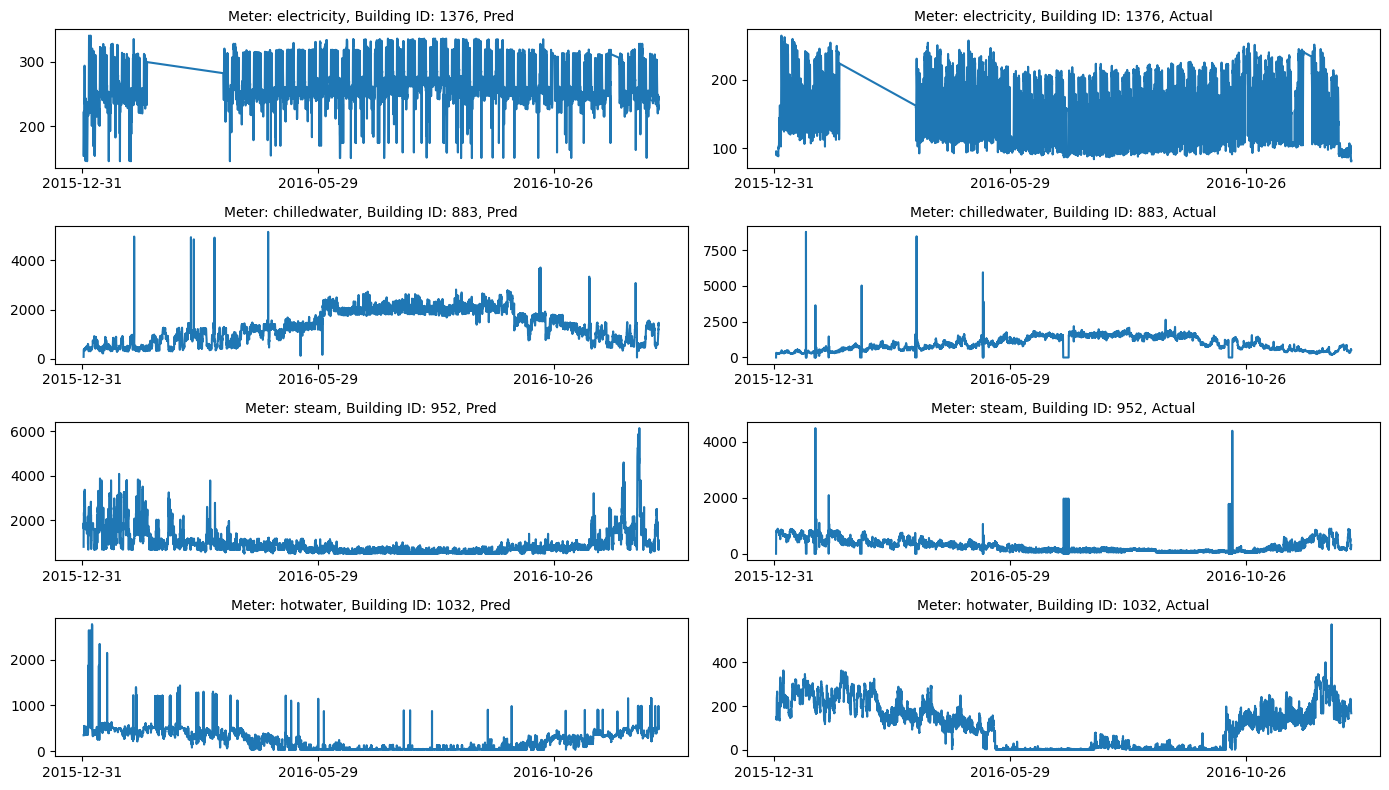

In [25]:
nrows, ncols = len(models), 2
fig, ax = plt.subplots(nrows, ncols, figsize=(14,8))

for row, model, meter_name, dataframe in zip(range(len(models)), models, meters, dataframes):
    # select a random building
    while True:
        bldg_sample = buildings.sample()
        building_id = bldg_sample.building_id.iloc[0]
        building_data = dataframe[dataframe["building_id"] == building_id].sort_values("timestamp")
        if len(building_data):
            break
    eval_dataframe = building_data[fields]
    meter_readings_pred = model.predict(eval_dataframe)

    cax = plt.subplot(nrows, ncols, 2 * row + 1)
    cax.plot(building_data['timestamp'].values, meter_readings_pred)
    cax.xaxis.set_major_locator(plt.MaxNLocator(3))
    cax.set_title('Meter: {}, Building ID: {}, Pred'.format(meter_name, building_id), fontsize=10)
    
    cax_real = plt.subplot(nrows, ncols, 2 * row + 2)
    cax_real.plot(building_data['timestamp'].values, building_data['meter_reading'].values)
    cax_real.xaxis.set_major_locator(plt.MaxNLocator(3))
    cax_real.set_title('Meter: {}, Building ID: {}, Actual'.format(meter_name, building_id), fontsize=10)
    
plt.tight_layout()
plt.show()

In [27]:
# pickle
import pickle
with open('models.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(primary_use_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)